# Initialization

In [1]:
##load packages: all versions used are listed here in case of conflict between packages for future versions
import pandas as pd   # version 2.2.3
import numpy as np  # version 1.26.2
import matplotlib.pyplot as plt    # version 3.6.0                                                   
from sklearn.multioutput import MultiOutputRegressor  # version 1.5.1                   
import joblib     #version   1.4.2                                                          
import time       
from xgboost import XGBRegressor   #version 2.1.4
import xgboost

file_path_weather="Weather.csv"    #extracted from the Ottawa weather file, specific fields can be outputted as a csv using E+ outputs
weather=pd.read_csv(file_path_weather)

In [2]:
MLElec=joblib.load(f'xgb_tuned_v2.sav')  #ML models were renamed for brevity
MLNG=joblib.load(f'xgb_NG.sav')
MLUnmet=joblib.load(f'xgb_Unmet.sav')
MLPeak=joblib.load(f'xgb_Peak.sav')

C:\Users\seifq\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator FunctionTransformer from version 1.5.0 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\seifq\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator TransformedTargetRegressor from version 1.5.0 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\seifq\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:54:36] WARNING: C:\b

# Optimizatiom

In [3]:
#intiialize variables

#define variables to be sampled from
from pymoo.core.variable import Choice #version 0.6.1.1 with  pull #653 of pymoo's repo implemented to run without errors
mixed_variables = {
    "X1_WallR" : Choice(options=[4.17,4.55,4.76,5.26,5.56,5.88,6.25,6.67,7.14]),
    "X2_RoofR" : Choice(options=[7.25,7.69,8.33,9.09,10]),
    "X3_WindowU":Choice(options=[1.315,1.45,1.488,1.627,1.665,1.73]),
    "X5_COPHigh" : Choice(options=[2.8,2.9,2.97,3.12,3.17,3.59,4.16]),
    "X7_HSP(7-21)" : Choice(options=np.linspace(16,22,61)),
    "X8_HSP(21-6)" : Choice(options=np.linspace(16,22,61)),
    "X9_CSP(6-21)" :Choice(options=np.linspace(22.1,28,60)),
    "X10_CSP(21-6)" : Choice(options=np.linspace(22.1,28,60)),
}

#append coupled values to sampled ones
windowu_to_shgc = {
    1.315:0.27, 1.45:0.184, 1.488:0.352, 1.627:0.288, 1.665:0.284,1.73:0.39
}
COPH_to_COPL = {
2.8:2.84, 2.9:2.67, 2.97:2.82, 3.12:2.98, 3.17:2.63, 3.59:3.59, 4.16:3.45
}
#define costs associated with each retrofit
costs = {
    "X1_WallR": {4.17:0, 4.55:285706.06, 4.76:222139.28, 5.26:229863.21,
    5.56:301153.93, 5.88:237587.14, 6.25:245311.08, 6.67:253167.5, 7.14:260904.68},
    "X2_RoofR": {7.25:0, 7.69:106485.37, 8.33: 111998.96, 9.09: 119007.20, 10: 126214.72},
    "X3_WindowU": {1.315:265349.28,1.450:229097.63,1.488:203180.28,
                1.627:337500.05,1.665:284979.88, 1.73:0},
    "X5_COPHigh": {2.8:0, 2.9:27499.08, 2.97:38692.73, 3.12:37885,
                   3.17:99540, 3.59:22279.68, 4.16:156715},    
}

In [4]:
#define optimization problem
import os
from pymoo.core.problem import Problem
from pymoo.optimize import minimize
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.core.variable import Variable
import PySAM.Pvwattsv8 as pv  #version 6.0.0
import PySAM.Grid as gr
import PySAM.Utilityrate5 as ur
import PySAM.Cashloan as co


class MOO(Problem):
    def __init__(self, base_load_profile_filename, **kwargs):
        super().__init__(vars=mixed_variables, n_obj=5, n_ieq_constr=0, **kwargs)
        
        # Initialize PySAM model (base configuration)
        self.base_system_model = pv.default('PVWattsCommercial')
        self.base_grid_model = gr.from_existing(self.base_system_model, 'PVWattsCommercial')
        self.base_utilityrate_model = ur.from_existing(self.base_system_model, 'PVWattsCommercial')
        self.base_financial_model = co.from_existing(self.base_system_model, 'PVWattsCommercial')
        
        # Load weather file associated with pySAM
        filename = f'ottawa_45.4218_-75.6912_psm3-2-2_60_2006.csv'
        self.base_system_model.SolarResource.solar_resource_file = filename

        # Load base load profile
        self.base_load_profile = pd.read_csv(base_load_profile_filename).values.flatten().tolist()

    def _evaluate(self, x, out, *args, **kwargs):
        predicted = pd.DataFrame(index=range(len(x)), columns=['-NPV', '-Self-Sufficiency', 'CO2e', 'Unmet Hours','Peak Load'])
        auxiliary_outputs = pd.DataFrame(index=range(len(x)), columns=['Total Installed Cost','Nameplate Capacity', 'Annual AC Generation','Annual Demand'])
        base_annual_load = 1842156291787.27
    
        for i in range(len(x)):
            # Create fresh copies of the PySAM models for this evaluation, to avoid double-counting costs
            system_model = pv.from_existing(self.base_system_model, 'PVWattsCommercial')
            grid_model = gr.from_existing(system_model, 'PVWattsCommercial')
            utilityrate_model = ur.from_existing(system_model, 'PVWattsCommercial')
            financial_model = co.from_existing(system_model, 'PVWattsCommercial')
            
            x_temp = pd.Series(x[i])
    
            # Calculate Retrofit Cost
            retrofit_cost = 0
            for var, value in x_temp.items():
                if var in costs:
                    if var == "X3_WindowU":
                        rounded_value = round(value, 3)
                    else:
                        rounded_value = round(value, 2)
                    retrofit_cost += costs[var].get(rounded_value, 0)
            retrofit_cost *= 0.7  # Convert to USD
    
            # Match X3_WindowU to X4_SHGC
            shgc_value = windowu_to_shgc[x_temp['X3_WindowU']]
            x_temp['X4_SHGC'] = shgc_value
    
            # Ensure X4_SHGC is in the correct position
            windowu_index = list(x_temp.index).index('X3_WindowU') + 1
            reordered_columns = x_temp.index.tolist()
            reordered_columns.remove('X4_SHGC')
            reordered_columns.insert(windowu_index, 'X4_SHGC')
            x_temp = x_temp[reordered_columns]
    
            # Match X5_COPHigh to X6_COPLow
            cop_low_value = COPH_to_COPL[x_temp['X5_COPHigh']]
            x_temp['X6_COPLow'] = cop_low_value
    
            # Ensure X6_COPLow is in the correct position
            cophigh_index = list(x_temp.index).index('X5_COPHigh') + 1
            reordered_columns = x_temp.index.tolist()
            reordered_columns.remove('X6_COPLow')
            reordered_columns.insert(cophigh_index, 'X6_COPLow')
            x_temp = x_temp[reordered_columns]
    
            # Convert x_temp to a DataFrame for the models
            x_temp_df = pd.DataFrame([x_temp])
            Annual_NG_load = MLNG.predict(x_temp_df)[0]
            Unmet_hr = MLUnmet.predict(x_temp_df)[0]
            Peak_Load = MLPeak.predict(x_temp_df)[0]
    
            # Prepare data for PMVSET model
            x_temp_df_weather = pd.DataFrame(np.tile(x_temp.values, (len(weather), 1)), columns=x_temp.index)
            df = pd.concat([weather, x_temp_df_weather], axis=1)
    
            Hourly_Elec_load = MLElec.predict(df)
            Hourly_Elec_kWh = Hourly_Elec_load / (3.6e6)
    
            grid_model.Load.load = Hourly_Elec_kWh
            
            Annual_Elec_load = Hourly_Elec_load.sum()
            
            # Determine the nameplate capacity based on the annual load
            Annual_load_kWh = Annual_Elec_load / (3.6e6)  # Converts from joules to kWh
            daily_load_kWh = Annual_load_kWh / 365
            efficiency = 0.96  # Inverter’s nominal rated DC-to-AC conversion efficiency, as a percentage
            PSH = 3.76  #Peak Sun Hours
            dc_ac = 1.2
            nameplate_capacity = dc_ac * (daily_load_kWh / (PSH * efficiency))
            system_model.SystemDesign.system_capacity = nameplate_capacity
            CO2_equivalent = 1.83*38*Annual_load_kWh+1.06*1921*26.853e-9*Annual_NG_load
            # Run the PySAM model to update the total installed cost based on the new system size
            system_model.execute()
            grid_model.execute()
            utilityrate_model.execute()
            financial_model.execute()
            
            # Extract the dynamic total installed cost from PySAM
            dynamic_total_installed_cost = financial_model.SystemCosts.total_installed_cost
    
            # Add retrofit costs to the dynamic total installed cost
            updated_total_installed_cost = dynamic_total_installed_cost + retrofit_cost
            financial_model.SystemCosts.total_installed_cost = updated_total_installed_cost
    
            financial_model.execute()
            npv = financial_model.Outputs.npv
            total_produced = system_model.Outputs.annual_energy  # kWh
    
            hourly_to_grid = list(utilityrate_model.Outputs.year1_hourly_e_togrid)
            to_grid = sum(hourly_to_grid)  # kWh
    
            sufficiency = (total_produced - to_grid) / Annual_load_kWh  
    
            # Store values in the predicted DataFrame
            predicted.at[i, '-NPV'] = -npv
            predicted.at[i, '-Self-Sufficiency'] = -sufficiency
            predicted.at[i, 'CO2e'] = CO2_equivalent / 1e6
            predicted.at[i, 'Unmet Hours'] = Unmet_hr
            predicted.at[i, 'Peak Load'] = Peak_Load
    
            auxiliary_outputs.at[i, 'Total Installed Cost'] = updated_total_installed_cost
            auxiliary_outputs.at[i, 'Nameplate Capacity'] = nameplate_capacity
            auxiliary_outputs.at[i, 'Annual AC Generation'] = total_produced
            auxiliary_outputs.at[i, 'Annual Demand'] = Annual_load_kWh
            # Print first 3 rows of auxiliary_outputs after each iteration
            
    
        out["F"] = predicted.to_numpy().astype(np.float64)
        auxiliary_outputs.to_csv("AuxiliaryOutputs.csv", index=False)
base_load_profile_filename = 'BaseCaseElectricity.csv'  #extracted from EnergyPlus as an output
problem = MOO(base_load_profile_filename)

In [5]:
#Define optimization algorithm

from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.algorithms.moo.unsga3 import UNSGA3
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.core.mixed import MixedVariableMating, MixedVariableSampling, MixedVariableDuplicateElimination
from pymoo.termination.default import DefaultMultiObjectiveTermination

# Define the axis-specific reference directions (one for each axis), see paper for source of parameters
M=5     #n_objectives
H_wanted=495    #n_reference points
p=8     #n_partitions

# Generate Das-Dennis reference directions
ref_dirs = get_reference_directions("das-dennis", M, n_partitions=p)

# Combine the axis-specific and Das-Dennis reference directions
if p<M:
    print(f"n_partitions is lower than M. n_partitions should be at least equal to M to give points in the interior of the simplex")


# Choose the population size as the smallest multiple of four greater than or equal to H_total
pop_size = 496

print(f"Total reference directions: {H_wanted}")
print(f"Population size: {pop_size}")

# Update algorithm to use NSGA-III with the generated reference directions
algorithm = UNSGA3(ref_dirs=ref_dirs,
                  pop_size=pop_size,
                  sampling=MixedVariableSampling(),
                  mating=MixedVariableMating(eliminate_duplicates=MixedVariableDuplicateElimination()),
                  mutation=PM(prob=1/len(mixed_variables)),
                  eliminate_duplicates=False) 

# Default termination:
termination = DefaultMultiObjectiveTermination(
    xtol=1e-8,
    # cvtol=1e-6,
    ftol=0.0025,
    period=30,
    # n_max_evals=1000000000,
    n_max_gen=200000
)


res = minimize(problem,
                   algorithm,
                   termination,
                   # seed=42,
                   verbose=True)
print(res.exec_time)

Total reference directions: 495
Population size: 496
n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      496 |     35 |             - |             -
     2 |      992 |     37 |  0.0670353529 |         ideal
     3 |     1488 |     48 |  0.0507812260 |         ideal
     4 |     1984 |     53 |  0.1259683752 |         nadir
     5 |     2480 |     50 |  0.0905095515 |         ideal
     6 |     2976 |     51 |  0.0118206411 |         ideal
     7 |     3472 |     47 |  0.0261918880 |         ideal
     8 |     3968 |     47 |  0.0044841648 |         ideal
     9 |     4464 |     50 |  0.0243299880 |         ideal
    10 |     4960 |     49 |  0.0797313205 |         ideal
    11 |     5456 |     50 |  0.0636071576 |         ideal
    12 |     5952 |     51 |  0.0673714093 |         ideal
    13 |     6448 |     54 |  0.0598346848 |         ideal
    14 |     6944 |     55 |  0.0594014790 |         ideal
    15 |     7440 |     56 |  0.0902035195 |         nadir
   

In [6]:
#extract results

# Variable and result names
X = pd.DataFrame(['X1_WallR','X2_RoofR', 'X3_WindowU','X4_SHGC','X5_COPHigh','X6_COPLow','X7_HSP(7-21)',
                  'X8_HSP(21-6)','X9_CSP(6-21)','X10_CSP(21-6)'])

F = pd.DataFrame(['-NPV', '-Self-Sufficiency', 'CO2e', 'Unmet Hours', 'Peak Load'])

df_X = pd.DataFrame(list(res.X))
df_F = pd.DataFrame(list(res.F))

#  Fix Self-Sufficiency column: Make positive & rename
df_F.columns = ['NPV', 'Self-Sufficiency', 'CO2e', 'Unmet Hours', 'Peak Load']
df_F['Self-Sufficiency'] = -df_F['Self-Sufficiency']  # Negate values
df_F['NPV'] = -df_F['NPV']
# Save CleanedOutputs.csv
df_F.to_csv('CleanedOutputs.csv', index=False)

#  Insert SHGC values after WindowU
shgc_values = df_X['X3_WindowU'].map(windowu_to_shgc)
windowu_index = df_X.columns.get_loc('X3_WindowU')
df_X.insert(windowu_index + 1, 'X4_SHGC', shgc_values)

#  Insert COPLow values after COPHigh
cop_low_values = df_X['X5_COPHigh'].map(COPH_to_COPL)
cophigh_index = df_X.columns.get_loc('X5_COPHigh')
df_X.insert(cophigh_index + 1, 'X6_COPLow', cop_low_values)

# Save CleanedInputs.csv
df_X.to_csv('CleanedInputs.csv', index=False)


df_results = pd.concat([df_X, df_F], axis=1)

# Save results.csv
df_results.to_csv('results.csv', index=False)



# Post-processing

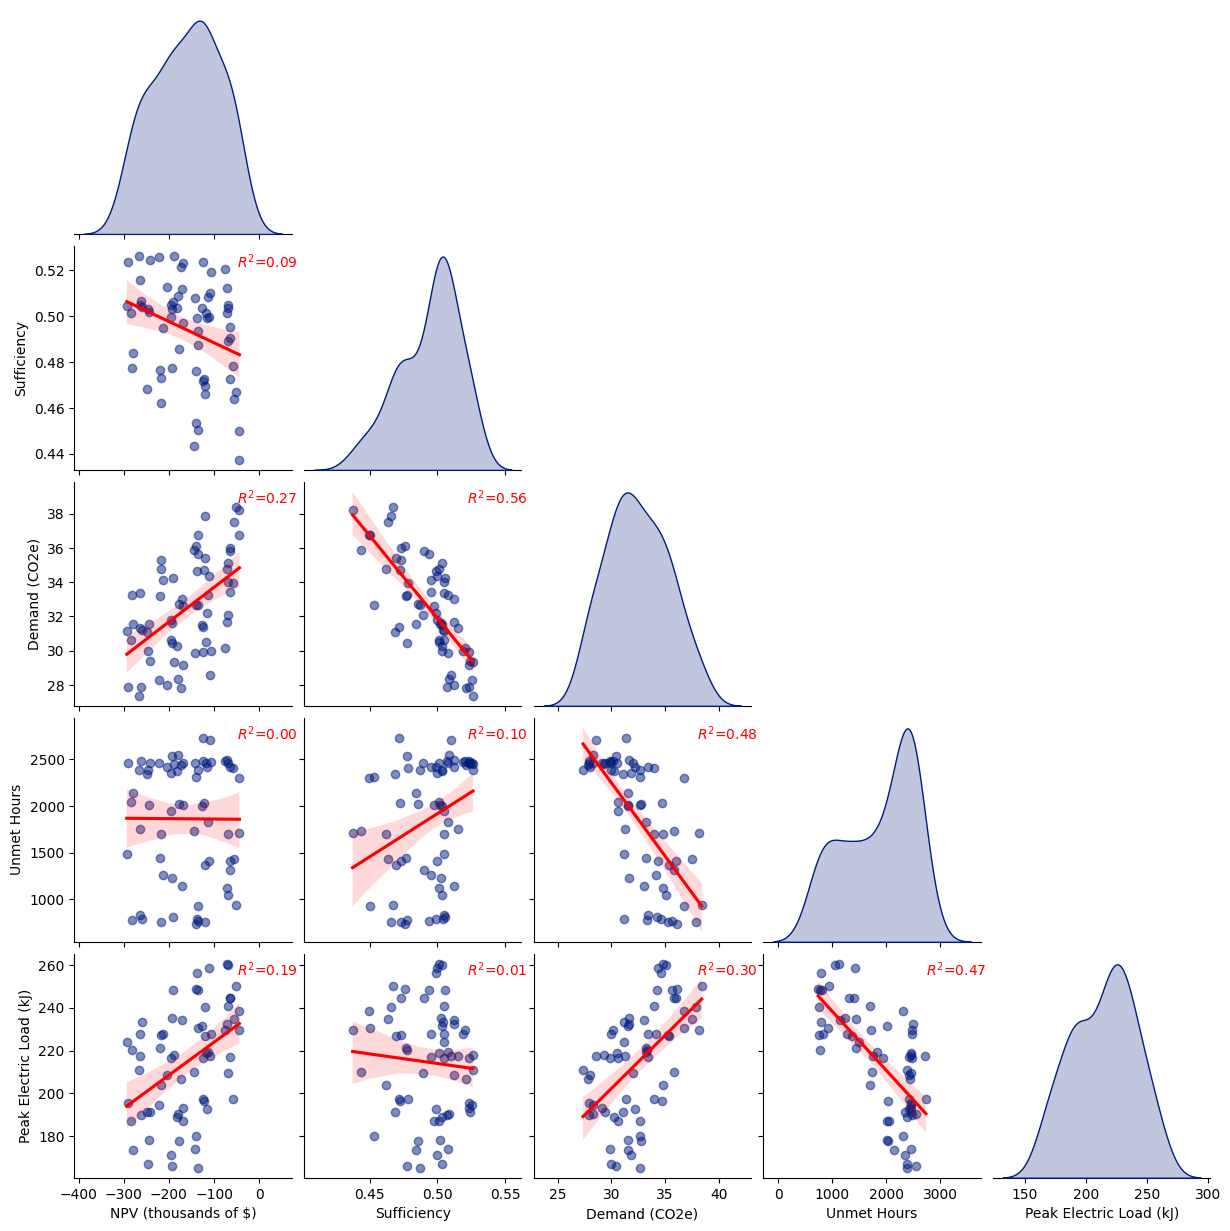

,NPV (thousands of $),Sufficiency,Demand (CO2e),Unmet Hours,Peak Electric Load (kJ)
NPV (thousands of $),1.000000,-0.297031,0.499082,0.006186,0.460332
Sufficiency,-0.297031,1.000000,-0.763030,0.430441,-0.107311
Demand (CO2e),0.499082,-0.763030,1.000000,-0.745989,0.581730
Unmet Hours,0.006186,0.430441,-0.745989,1.000000,-0.629939
Peak Electric Load (kJ),0.460332,-0.107311,0.581730,-0.629939,1.000000


In [7]:
import pandas as pd
import seaborn as sns    #version 0.13.2
import matplotlib.pyplot as plt
from scipy.stats import linregress   #version 1.13.1
import matplotlib.ticker as ticker

# Load the dataset
file_path_results = "CleanedOutputs.csv"
df_results = pd.read_csv(file_path_results)

# Set correct column names
headers = ['NPV (thousands of $)', 'Sufficiency', 'Demand (CO2e)', 'Unmet Hours', 'Peak Electric Load (kJ)']
df_results.columns = headers  

df_results['NPV (thousands of $)']= df_results['NPV (thousands of $)']/(0.7*1000)
df_results['Peak Electric Load (kJ)']= df_results['Peak Electric Load (kJ)']/1000



# Configure Seaborn styling
sns.set_palette("dark")

# Function to annotate R² on plots
def annotate_r2(x, y, **kwargs):
    ax = plt.gca()
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    r2_text = f'$R^2$={r_value**2:.2f}'  # Format R² with 2 decimal places
    ax.annotate(r2_text, xy=(0.75, 0.9), xycoords=ax.transAxes, fontsize=10, color='red')

# Create a pairplot with regression lines
pairplot = sns.pairplot(
    df_results,
    corner=True,
    diag_kind='kde',
    kind='reg',
    plot_kws={'line_kws': {'color': 'red'}, 'scatter_kws': {'alpha': 0.5}}
)

# Apply R² annotation to lower triangle
pairplot.map_lower(annotate_r2)

output_filename = "pairplot_results.png"  # Change the filename if needed
plt.savefig(output_filename, dpi=300, bbox_inches='tight')  # Save with high resolution


plt.show()
df_results.corr(method='spearman')

#spearman coeffs were added to image manually using LaTeX TikZ

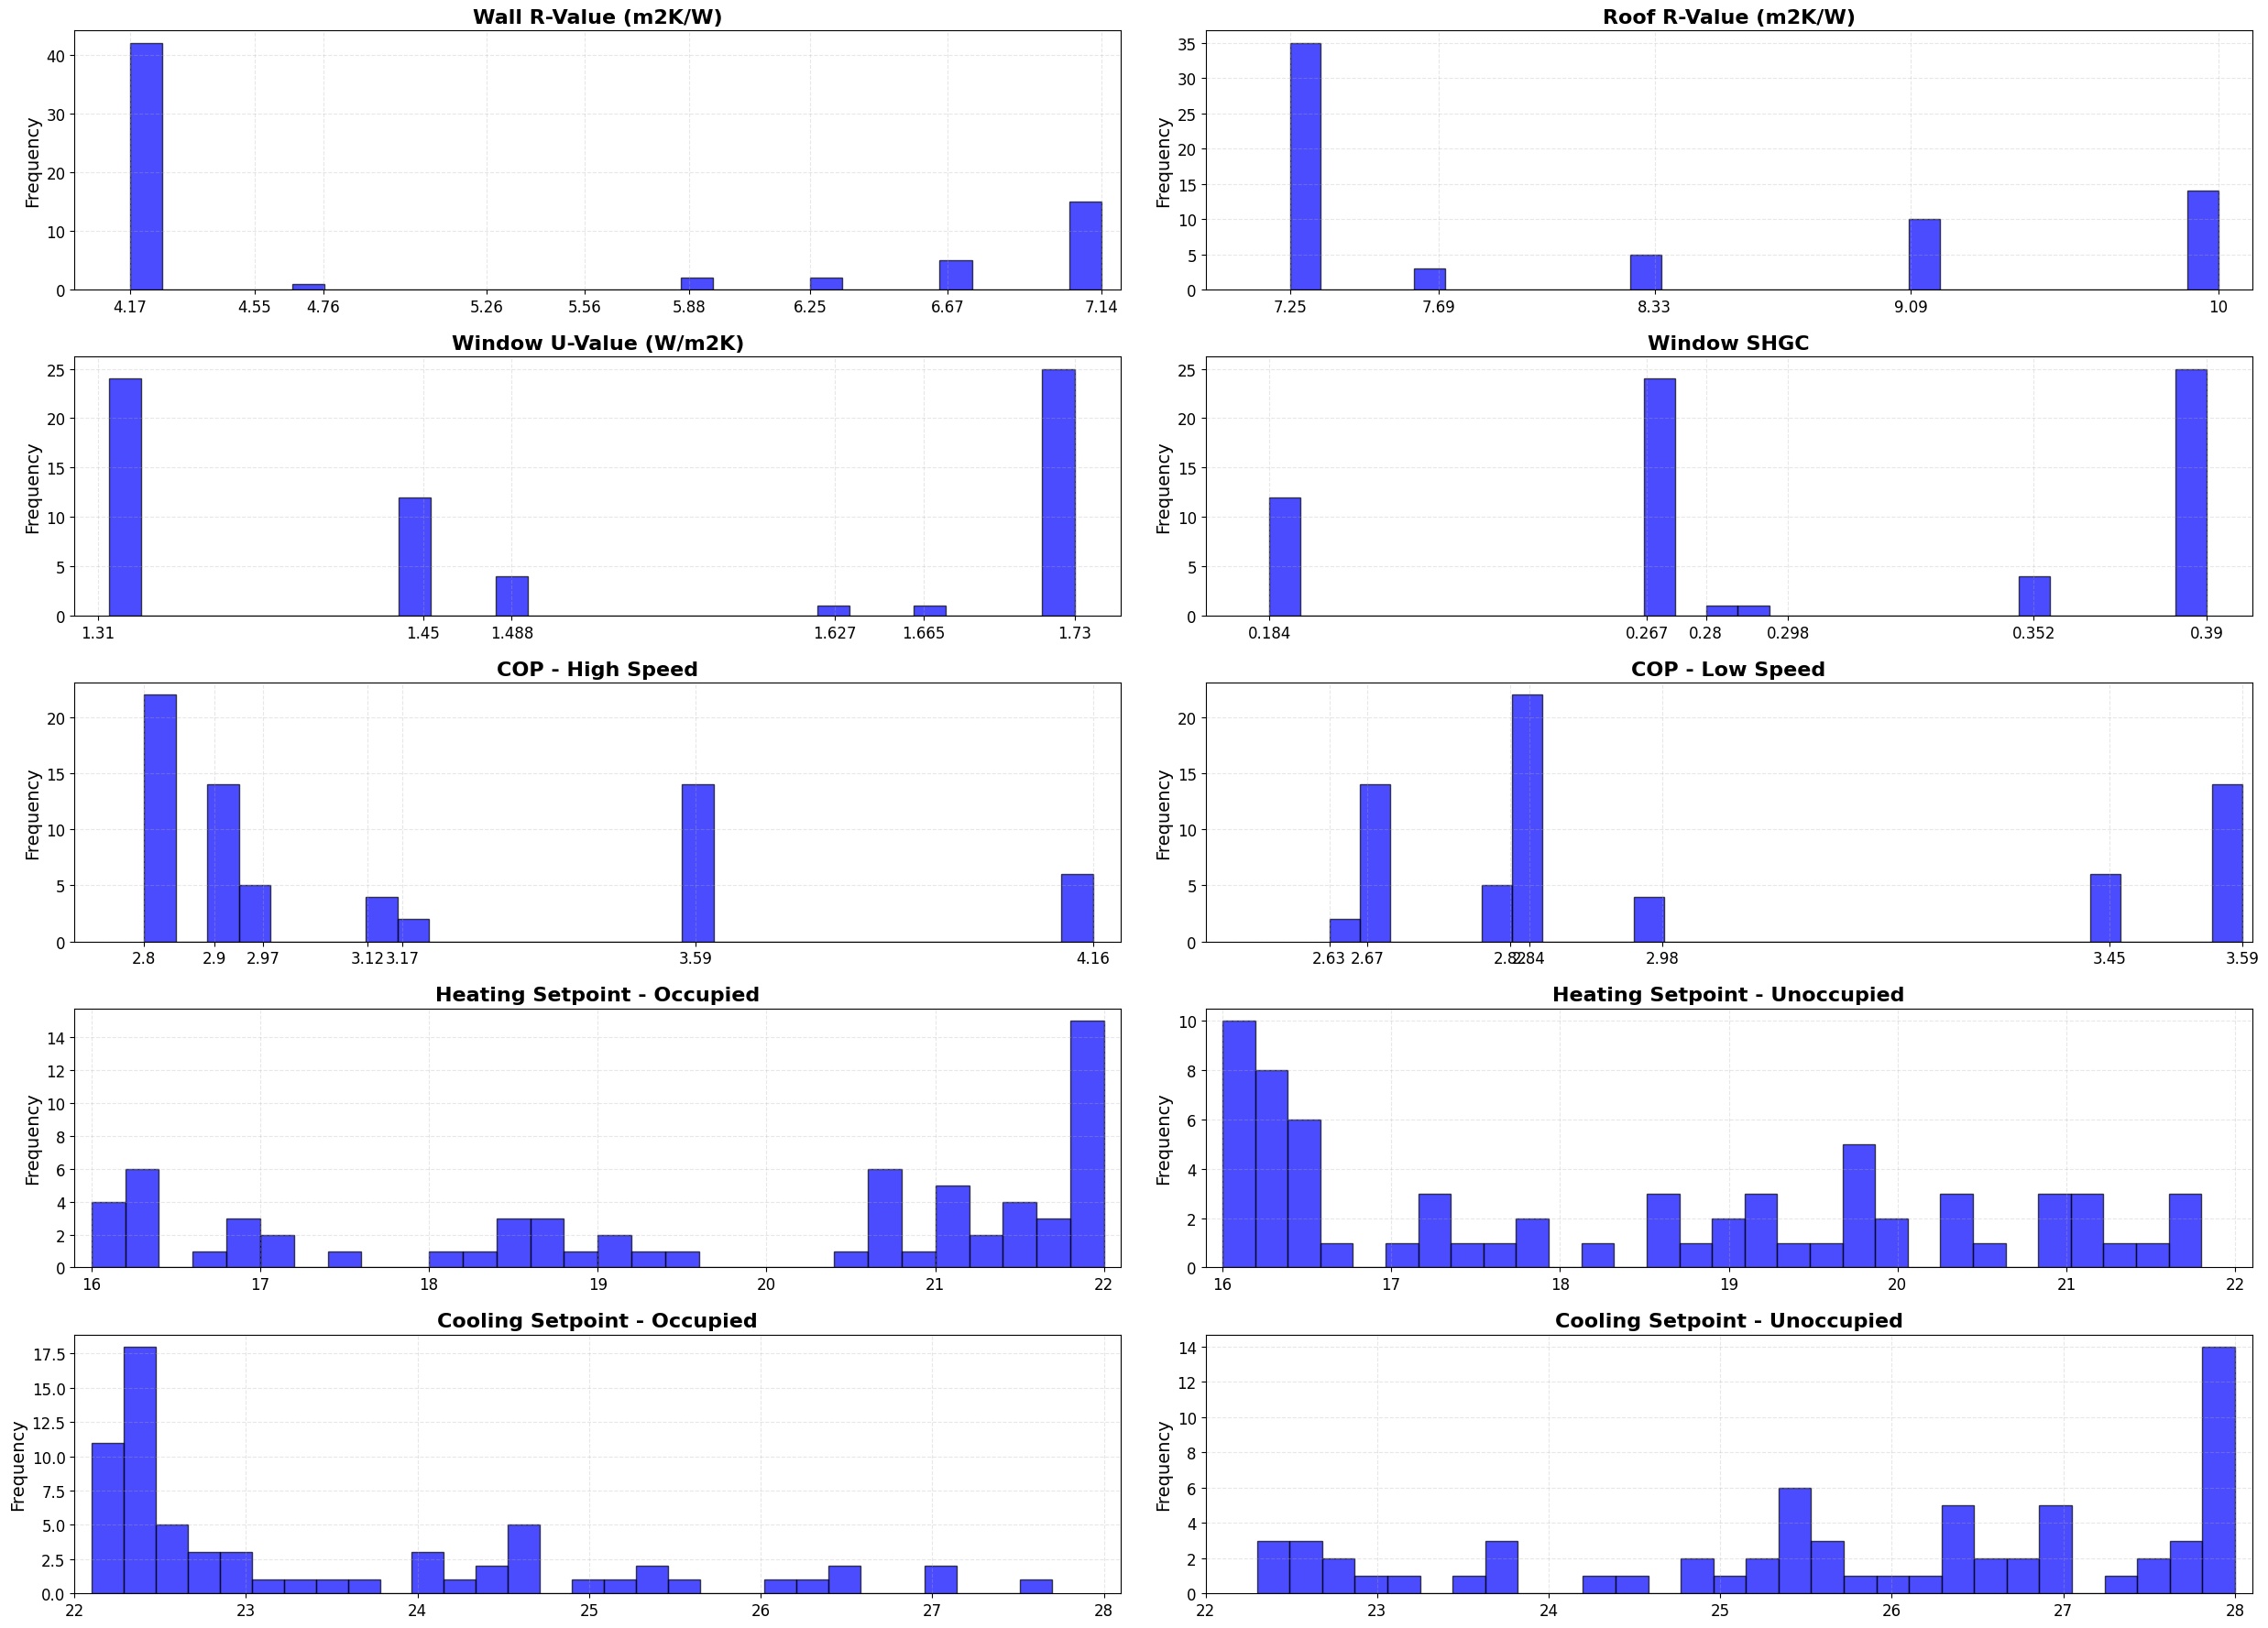

In [9]:
#input distribution -- one in paper did not have custom x-axis because it needed to be too wide

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load the dataset
df_inputs = pd.read_csv("CleanedInputs.csv")

# Convert all columns to numeric
df_inputs = df_inputs.apply(pd.to_numeric, errors='coerce')

# Define column headers
headers = ['Wall R-Value (m2K/W)', 'Roof R-Value (m2K/W)', 'Window U-Value (W/m2K)', 'Window SHGC', 
           'COP - High Speed', 'COP - Low Speed', 'Heating Setpoint - Occupied',
           'Heating Setpoint - Unoccupied','Cooling Setpoint - Occupied','Cooling Setpoint - Unoccupied']

# Assign headers
df_inputs.columns = headers

# Define custom x-axis limits (for all plots)
x_limits = {
    'Wall R-Value (m2K/W)': (4, 7.2),
    'Roof R-Value (m2K/W)': (7, 10.1),
    'Window U-Value (W/m2K)': (1.3, 1.75),
    'Window SHGC': (0.17, 0.4),
    'COP - High Speed': (2.7, 4.2),
    'COP - Low Speed': (2.5, 3.6),
    'Heating Setpoint - Occupied': (15.9, 22.1),
    'Heating Setpoint - Unoccupied': (15.9, 22.1),
    'Cooling Setpoint - Occupied': (22, 28.1),
    'Cooling Setpoint - Unoccupied': (22, 28.1)
}

# Define explicit x-ticks (only for the first 6 plots)
x_ticks = {
    'Wall R-Value (m2K/W)':       [4.17, 4.55, 4.76, 5.26, 5.56, 5.88, 6.25, 6.67, 7.14],
    'Roof R-Value (m2K/W)':       [7.25, 7.69, 8.33, 9.09, 10.0],
    'Window U-Value (W/m2K)':     [1.31, 1.45, 1.488, 1.627, 1.665, 1.73],
    'Window SHGC':                [0.184, 0.267, 0.28, 0.298, 0.352, 0.39],
    'COP - High Speed':           [2.8, 2.9, 2.97, 3.12, 3.17,3.59, 4.16],
    'COP - Low Speed':            [2.63, 2.67, 2.82, 2.84, 2.98, 3.45, 3.59]
}

# Set global font sizes
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12
})

# Create figure with two columns
fig, axes = plt.subplots(5, 2, figsize=(25, 18))

# Flatten axes for easy iteration
axes = axes.flatten()

# Plot histograms
for i, col in enumerate(headers):
    ax = axes[i]
    ax.hist(df_inputs[col], bins=30, color='blue', alpha=0.7, edgecolor='black')

    # Set x-axis limits
    ax.set_xlim(x_limits[col])

    # Set x-axis ticks for the first 6 plots
    if i < 6:
        ticks = x_ticks[col]
        ax.set_xticks(ticks)
        ax.set_xticklabels([str(t).rstrip('0').rstrip('.') if '.' in str(t) else str(t) for t in ticks])
    # Titles and labels
    ax.set_title(col, fontweight='bold')
    ax.set_ylabel('Frequency')
    ax.grid(True, linestyle='--', alpha=0.3)


# Adjust layout
plt.tight_layout()

# Save and show
plt.savefig("input_parameters_histograms.png", dpi=300, bbox_inches='tight')
plt.show()
